In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

In [6]:
!pip install torch.geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
import os
from google.colab import files
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv

# Ignore everything above

In [8]:
"""def impute_data(raw_data_path, year):
  df = pd.read_parquet(raw_data_path)
  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]
  df = pd.DataFrame(df_filtered)
  df = df.set_index('valid')
  df.index = df.index.floor('H')

  start_date = pd.to_datetime(f'{year}-01-01').floor('D')
  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)
  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')
  complete_df = pd.DataFrame(index=complete_index)

  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')
  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
  imputed_df = merged_df.fillna(method='ffill')
  return imputed_df

for filename in os.listdir('./raw_WI_data'):
    if '.parquet' not in filename:
      continue
    dataframe = impute_data('./raw_WI_data/' + filename, 2021)
    if len(dataframe) == 8760:
      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')
"""

"def impute_data(raw_data_path, year):\n  df = pd.read_parquet(raw_data_path)\n  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]\n  df = pd.DataFrame(df_filtered)\n  df = df.set_index('valid')\n  df.index = df.index.floor('H')\n\n  start_date = pd.to_datetime(f'{year}-01-01').floor('D')\n  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)\n  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')\n  complete_df = pd.DataFrame(index=complete_index)\n\n  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')\n  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]\n  imputed_df = merged_df.fillna(method='ffill')\n  return imputed_df\n\nfor filename in os.listdir('./raw_WI_data'):\n    if '.parquet' not in filename:\n      continue\n    dataframe = impute_data('./raw_WI_data/' + filename, 2021)\n    if len(dataframe) == 8760:\n      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')\n"

In [9]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    station_data.append(np.array(pm25_df["Value"].values).reshape(-1, 1))

In [10]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [11]:
# NORMALIZING
normalized_station_data = []
for stat in station_data:
  train_size = int(len(stat) * 0.70)
  test_size = len(stat) - train_size

  #stat = stat.astype('float32')
  stat_train, stat_test = stat[:train_size], stat[train_size:]
  #scaler = preprocessing.StandardScaler().fit(stat_train)
  #stat_train = scaler.transform(stat_train)
  #stat_test = scaler.transform(stat_test)

  normalized_station_data.append([stat_train, stat_test])

print(len(normalized_station_data))

17


In [12]:
lookback = 7
station_train_dataset = []
station_test_dataset = []
for stat in normalized_station_data:
  X_train, y_train = create_dataset(stat[0], lookback=lookback)
  X_test, y_test = create_dataset(stat[1], lookback=lookback)
  station_train_dataset.append([X_train, y_train])
  station_test_dataset.append([X_test, y_test])

In [13]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [14]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='b')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()

PM 2.5 Model
Epoch 0: train RMSE 1.9148, test RMSE 1.8628, train R2 0.9224, test R2 0.8638
Epoch 1: train RMSE 1.8073, test RMSE 1.8408, train R2 0.9309, test R2 0.8670
Epoch 2: train RMSE 1.9100, test RMSE 1.9081, train R2 0.9228, test R2 0.8571
Epoch 3: train RMSE 1.7300, test RMSE 1.8975, train R2 0.9367, test R2 0.8586
Epoch 4: train RMSE 1.7590, test RMSE 1.9057, train R2 0.9346, test R2 0.8574
Epoch 5: train RMSE 1.7774, test RMSE 1.8716, train R2 0.9332, test R2 0.8625
Epoch 6: train RMSE 1.9547, test RMSE 2.1229, train R2 0.9192, test R2 0.8231
Epoch 7: train RMSE 1.7960, test RMSE 1.9161, train R2 0.9318, test R2 0.8559
Epoch 8: train RMSE 1.7404, test RMSE 1.9637, train R2 0.9359, test R2 0.8486
Epoch 9: train RMSE 1.7085, test RMSE 1.9370, train R2 0.9383, test R2 0.8527


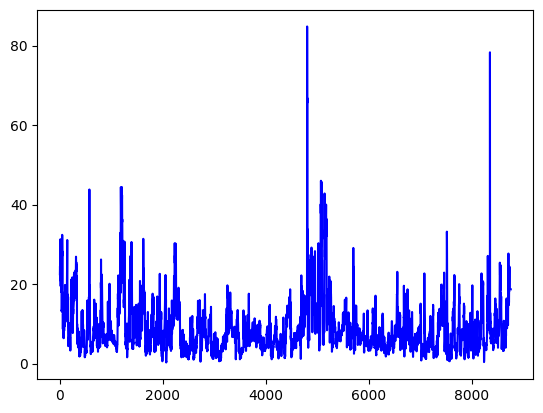

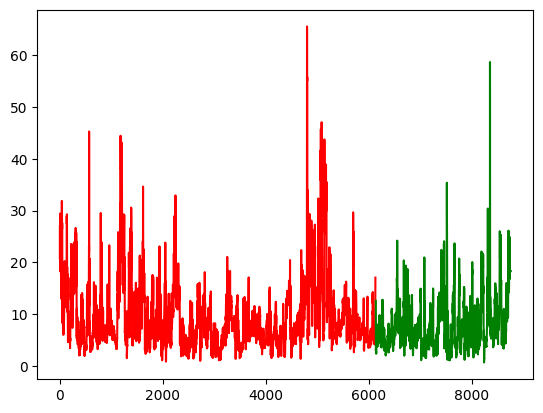

PM 2.5 Model
Epoch 0: train RMSE 2.2723, test RMSE 1.8654, train R2 0.9164, test R2 0.8600
Epoch 1: train RMSE 2.2677, test RMSE 1.8495, train R2 0.9167, test R2 0.8624
Epoch 2: train RMSE 2.2634, test RMSE 1.9225, train R2 0.9170, test R2 0.8513
Epoch 3: train RMSE 2.2398, test RMSE 1.9158, train R2 0.9188, test R2 0.8524
Epoch 4: train RMSE 2.1305, test RMSE 1.8264, train R2 0.9265, test R2 0.8658
Epoch 5: train RMSE 2.1543, test RMSE 1.8703, train R2 0.9248, test R2 0.8593
Epoch 6: train RMSE 2.1544, test RMSE 1.8866, train R2 0.9248, test R2 0.8568
Epoch 7: train RMSE 2.1158, test RMSE 1.8295, train R2 0.9275, test R2 0.8654
Epoch 8: train RMSE 2.1590, test RMSE 1.8763, train R2 0.9245, test R2 0.8584
Epoch 9: train RMSE 2.2390, test RMSE 1.9049, train R2 0.9188, test R2 0.8540


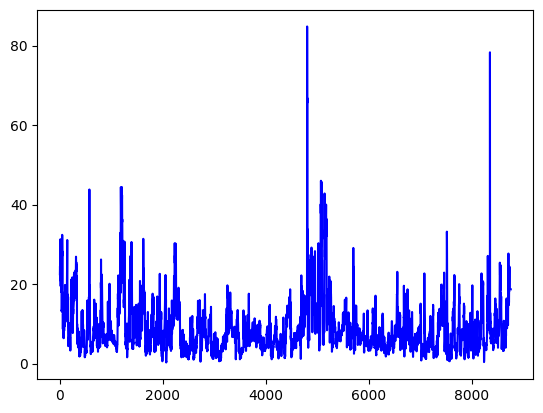

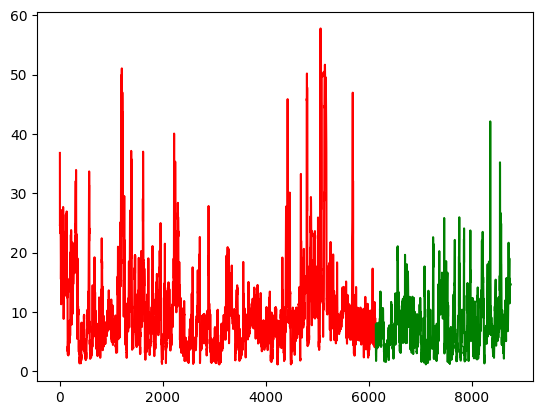

PM 2.5 Model
Epoch 0: train RMSE 1.7258, test RMSE 2.2293, train R2 0.9302, test R2 0.8367
Epoch 1: train RMSE 1.6776, test RMSE 2.2199, train R2 0.9341, test R2 0.8381
Epoch 2: train RMSE 1.6698, test RMSE 2.2591, train R2 0.9347, test R2 0.8323
Epoch 3: train RMSE 1.6112, test RMSE 2.2440, train R2 0.9392, test R2 0.8346
Epoch 4: train RMSE 1.5487, test RMSE 2.1907, train R2 0.9438, test R2 0.8423
Epoch 5: train RMSE 1.6094, test RMSE 2.2015, train R2 0.9393, test R2 0.8408
Epoch 6: train RMSE 1.6455, test RMSE 2.2644, train R2 0.9366, test R2 0.8316
Epoch 7: train RMSE 1.6017, test RMSE 2.2360, train R2 0.9399, test R2 0.8358
Epoch 8: train RMSE 1.5962, test RMSE 2.2030, train R2 0.9403, test R2 0.8406
Epoch 9: train RMSE 1.5614, test RMSE 2.1918, train R2 0.9429, test R2 0.8422


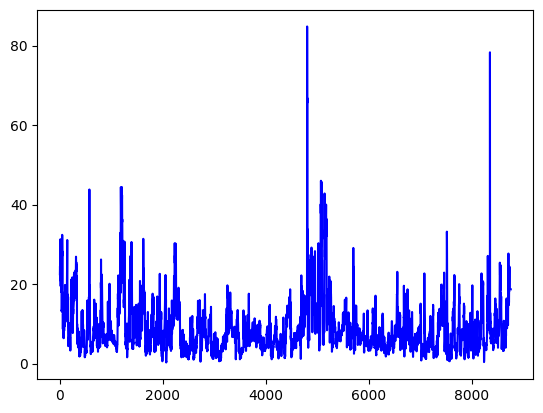

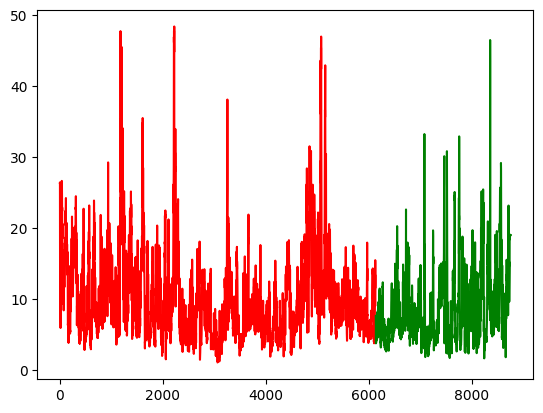

PM 2.5 Model
Epoch 0: train RMSE 4.1877, test RMSE 3.2548, train R2 0.7142, test R2 0.7485
Epoch 1: train RMSE 4.1714, test RMSE 3.2170, train R2 0.7165, test R2 0.7543
Epoch 2: train RMSE 4.1431, test RMSE 3.2038, train R2 0.7203, test R2 0.7564
Epoch 3: train RMSE 4.1570, test RMSE 3.1453, train R2 0.7184, test R2 0.7652
Epoch 4: train RMSE 4.1352, test RMSE 3.1805, train R2 0.7213, test R2 0.7599
Epoch 5: train RMSE 4.1574, test RMSE 3.1512, train R2 0.7184, test R2 0.7643
Epoch 6: train RMSE 4.1285, test RMSE 3.1936, train R2 0.7223, test R2 0.7579
Epoch 7: train RMSE 4.1132, test RMSE 3.1884, train R2 0.7243, test R2 0.7587
Epoch 8: train RMSE 4.1303, test RMSE 3.2214, train R2 0.7220, test R2 0.7537
Epoch 9: train RMSE 4.1129, test RMSE 3.1379, train R2 0.7243, test R2 0.7663


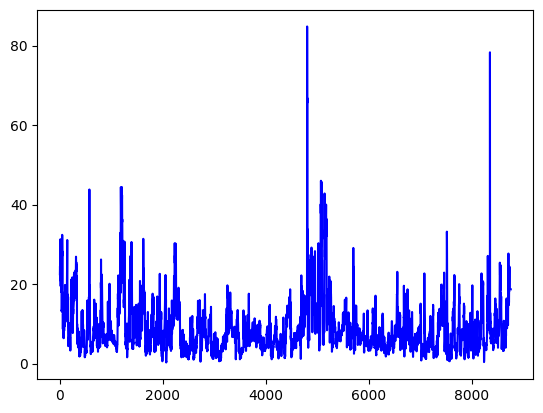

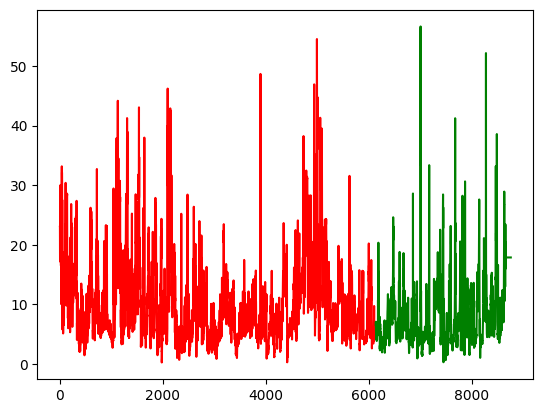

PM 2.5 Model
Epoch 0: train RMSE 3.6235, test RMSE 1.8500, train R2 0.8446, test R2 0.8014
Epoch 1: train RMSE 2.9929, test RMSE 1.8393, train R2 0.8940, test R2 0.8037
Epoch 2: train RMSE 2.7363, test RMSE 1.8038, train R2 0.9114, test R2 0.8112
Epoch 3: train RMSE 2.5295, test RMSE 1.7546, train R2 0.9243, test R2 0.8214
Epoch 4: train RMSE 2.4602, test RMSE 2.0240, train R2 0.9284, test R2 0.7623
Epoch 5: train RMSE 2.5796, test RMSE 1.8255, train R2 0.9212, test R2 0.8066
Epoch 6: train RMSE 2.6395, test RMSE 1.9926, train R2 0.9175, test R2 0.7696
Epoch 7: train RMSE 2.4182, test RMSE 2.0058, train R2 0.9308, test R2 0.7665
Epoch 8: train RMSE 2.2960, test RMSE 1.9757, train R2 0.9376, test R2 0.7735
Epoch 9: train RMSE 2.3384, test RMSE 1.9982, train R2 0.9353, test R2 0.7683


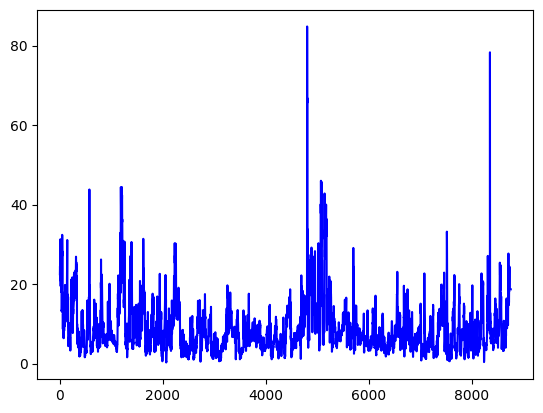

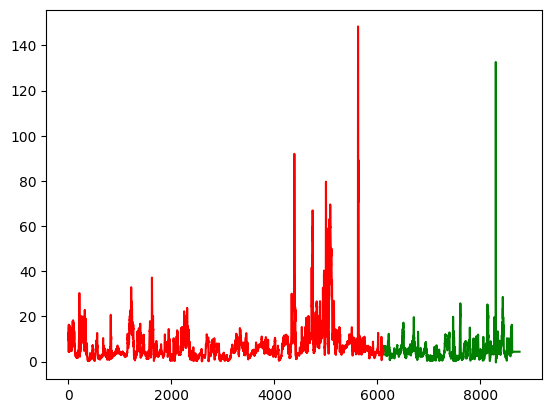

PM 2.5 Model
Epoch 0: train RMSE 4.0915, test RMSE 1.6529, train R2 0.8148, test R2 0.8284
Epoch 1: train RMSE 3.5010, test RMSE 1.5836, train R2 0.8644, test R2 0.8425
Epoch 2: train RMSE 2.8061, test RMSE 1.6243, train R2 0.9129, test R2 0.8343
Epoch 3: train RMSE 2.9382, test RMSE 1.5083, train R2 0.9045, test R2 0.8571
Epoch 4: train RMSE 2.5216, test RMSE 1.6638, train R2 0.9297, test R2 0.8261
Epoch 5: train RMSE 2.3188, test RMSE 1.7206, train R2 0.9405, test R2 0.8140
Epoch 6: train RMSE 2.5179, test RMSE 1.6972, train R2 0.9299, test R2 0.8190
Epoch 7: train RMSE 2.2613, test RMSE 1.8650, train R2 0.9434, test R2 0.7815
Epoch 8: train RMSE 2.5472, test RMSE 1.9806, train R2 0.9282, test R2 0.7536
Epoch 9: train RMSE 2.0867, test RMSE 1.7769, train R2 0.9518, test R2 0.8017


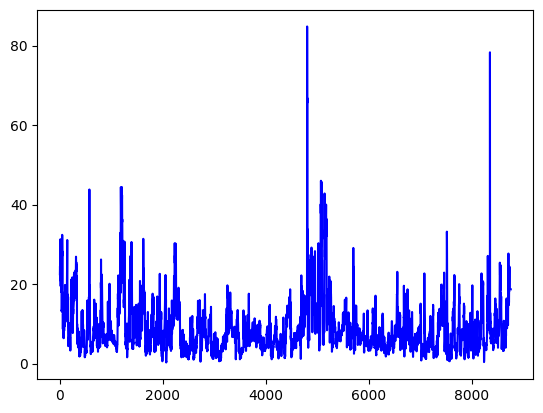

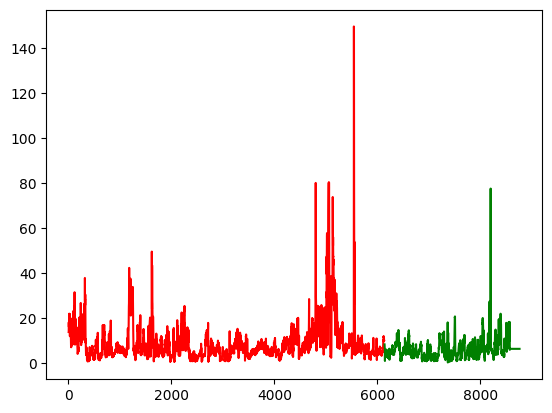

PM 2.5 Model
Epoch 0: train RMSE 1.6907, test RMSE 2.2836, train R2 0.9410, test R2 0.7836
Epoch 1: train RMSE 1.6484, test RMSE 2.3238, train R2 0.9439, test R2 0.7759
Epoch 2: train RMSE 1.7232, test RMSE 2.3334, train R2 0.9387, test R2 0.7740
Epoch 3: train RMSE 1.8324, test RMSE 2.2540, train R2 0.9307, test R2 0.7892
Epoch 4: train RMSE 1.6099, test RMSE 2.3004, train R2 0.9465, test R2 0.7804
Epoch 5: train RMSE 1.6386, test RMSE 2.3438, train R2 0.9446, test R2 0.7720
Epoch 6: train RMSE 1.6525, test RMSE 2.3174, train R2 0.9436, test R2 0.7771
Epoch 7: train RMSE 1.6294, test RMSE 2.3362, train R2 0.9452, test R2 0.7735
Epoch 8: train RMSE 1.5569, test RMSE 2.3104, train R2 0.9499, test R2 0.7785
Epoch 9: train RMSE 1.5804, test RMSE 2.2284, train R2 0.9484, test R2 0.7939


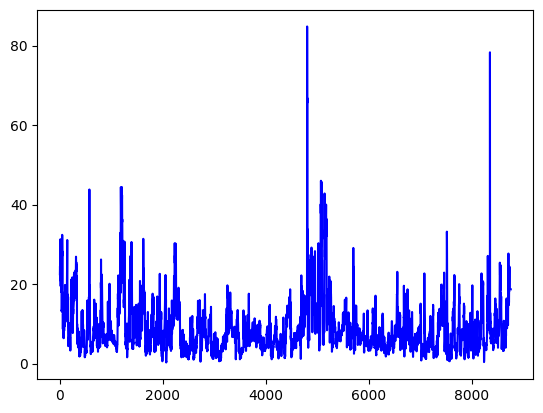

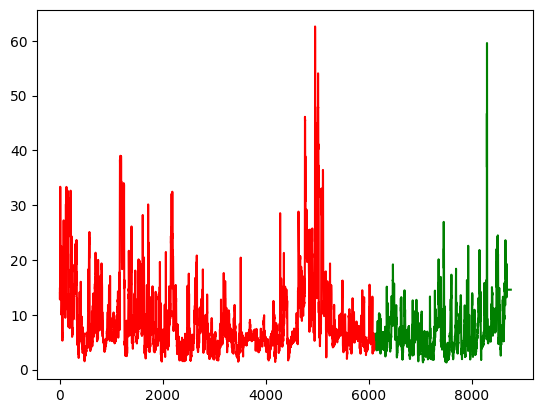

PM 2.5 Model
Epoch 0: train RMSE 2.5166, test RMSE 2.6734, train R2 0.8810, test R2 0.8180
Epoch 1: train RMSE 2.3419, test RMSE 2.6600, train R2 0.8969, test R2 0.8199
Epoch 2: train RMSE 2.4188, test RMSE 2.7249, train R2 0.8900, test R2 0.8110
Epoch 3: train RMSE 2.3015, test RMSE 2.7563, train R2 0.9005, test R2 0.8066
Epoch 4: train RMSE 2.3738, test RMSE 2.7128, train R2 0.8941, test R2 0.8126
Epoch 5: train RMSE 2.4021, test RMSE 2.8513, train R2 0.8916, test R2 0.7930
Epoch 6: train RMSE 2.2784, test RMSE 2.7095, train R2 0.9024, test R2 0.8131
Epoch 7: train RMSE 2.2320, test RMSE 2.7591, train R2 0.9064, test R2 0.8062
Epoch 8: train RMSE 2.3834, test RMSE 2.9005, train R2 0.8932, test R2 0.7858
Epoch 9: train RMSE 2.2472, test RMSE 2.7350, train R2 0.9051, test R2 0.8096


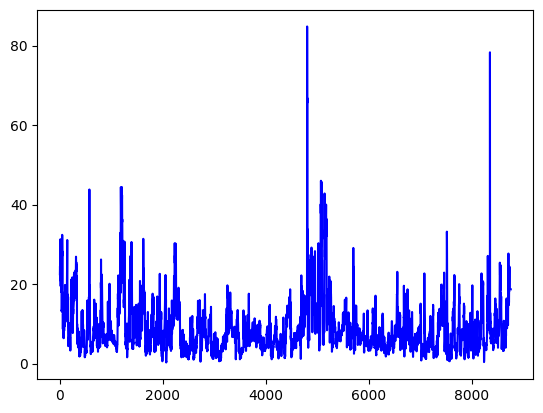

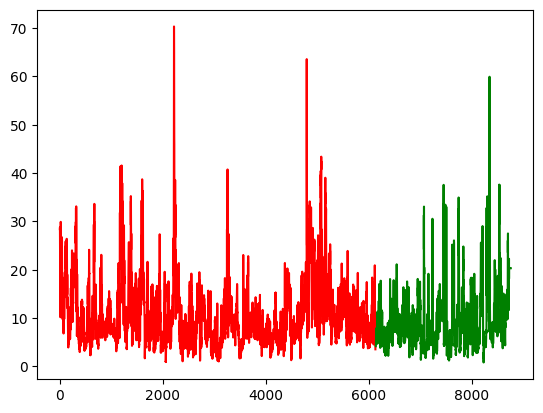

PM 2.5 Model
Epoch 0: train RMSE 1.6994, test RMSE 1.6941, train R2 0.9253, test R2 0.8496
Epoch 1: train RMSE 1.6360, test RMSE 1.6765, train R2 0.9307, test R2 0.8528
Epoch 2: train RMSE 1.5464, test RMSE 1.5990, train R2 0.9381, test R2 0.8660
Epoch 3: train RMSE 1.6117, test RMSE 1.5718, train R2 0.9328, test R2 0.8706
Epoch 4: train RMSE 1.5992, test RMSE 1.6443, train R2 0.9338, test R2 0.8584
Epoch 5: train RMSE 1.5860, test RMSE 1.5928, train R2 0.9349, test R2 0.8671
Epoch 6: train RMSE 1.4913, test RMSE 1.5667, train R2 0.9424, test R2 0.8714
Epoch 7: train RMSE 1.6517, test RMSE 1.6933, train R2 0.9294, test R2 0.8498
Epoch 8: train RMSE 1.5195, test RMSE 1.5606, train R2 0.9402, test R2 0.8724
Epoch 9: train RMSE 1.4809, test RMSE 1.5722, train R2 0.9432, test R2 0.8705


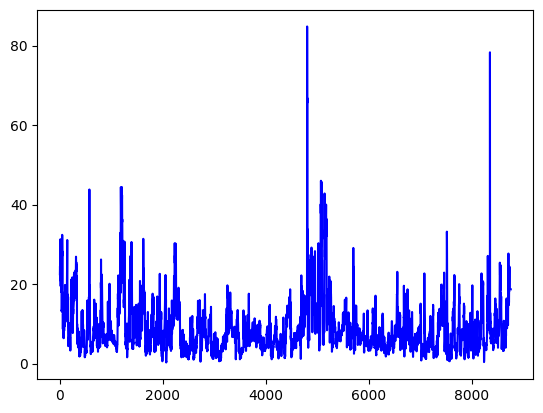

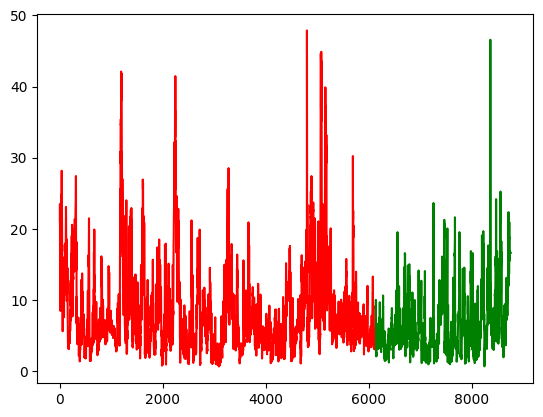

PM 2.5 Model
Epoch 0: train RMSE 3.7936, test RMSE 1.3568, train R2 0.7883, test R2 0.8667
Epoch 1: train RMSE 3.9121, test RMSE 1.3898, train R2 0.7749, test R2 0.8601
Epoch 2: train RMSE 3.6467, test RMSE 1.3907, train R2 0.8044, test R2 0.8599
Epoch 3: train RMSE 3.7164, test RMSE 1.5088, train R2 0.7969, test R2 0.8351
Epoch 4: train RMSE 3.6296, test RMSE 1.4488, train R2 0.8062, test R2 0.8480
Epoch 5: train RMSE 3.5685, test RMSE 1.3710, train R2 0.8127, test R2 0.8639
Epoch 6: train RMSE 3.5963, test RMSE 1.5421, train R2 0.8098, test R2 0.8278
Epoch 7: train RMSE 3.6875, test RMSE 1.5905, train R2 0.8000, test R2 0.8168
Epoch 8: train RMSE 3.5511, test RMSE 1.4269, train R2 0.8145, test R2 0.8525
Epoch 9: train RMSE 3.4976, test RMSE 1.4701, train R2 0.8201, test R2 0.8435


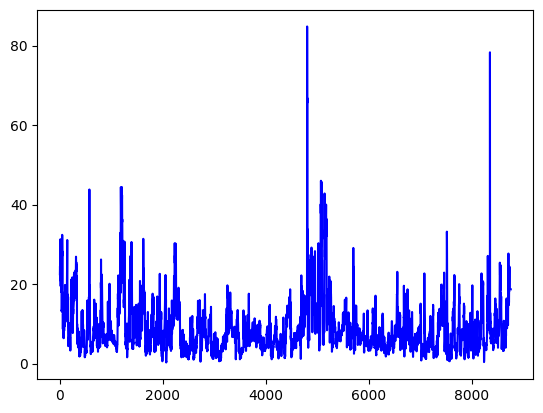

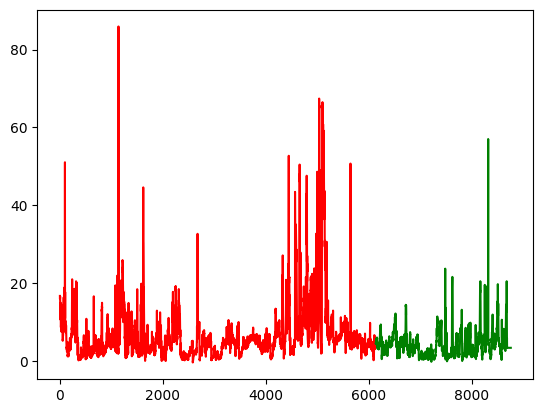

PM 2.5 Model
Epoch 0: train RMSE 2.4160, test RMSE 2.4716, train R2 0.8866, test R2 0.8071
Epoch 1: train RMSE 2.5804, test RMSE 2.5305, train R2 0.8706, test R2 0.7978
Epoch 2: train RMSE 2.1803, test RMSE 2.4250, train R2 0.9076, test R2 0.8143
Epoch 3: train RMSE 2.2481, test RMSE 2.3671, train R2 0.9018, test R2 0.8230
Epoch 4: train RMSE 2.1422, test RMSE 2.3399, train R2 0.9108, test R2 0.8271
Epoch 5: train RMSE 2.2498, test RMSE 2.4134, train R2 0.9017, test R2 0.8160
Epoch 6: train RMSE 2.1458, test RMSE 2.3961, train R2 0.9105, test R2 0.8187
Epoch 7: train RMSE 2.0859, test RMSE 2.3863, train R2 0.9155, test R2 0.8202
Epoch 8: train RMSE 2.2796, test RMSE 2.4141, train R2 0.8990, test R2 0.8159
Epoch 9: train RMSE 2.1335, test RMSE 2.4415, train R2 0.9116, test R2 0.8117


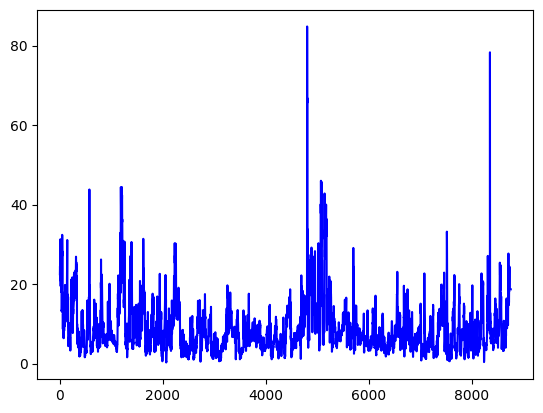

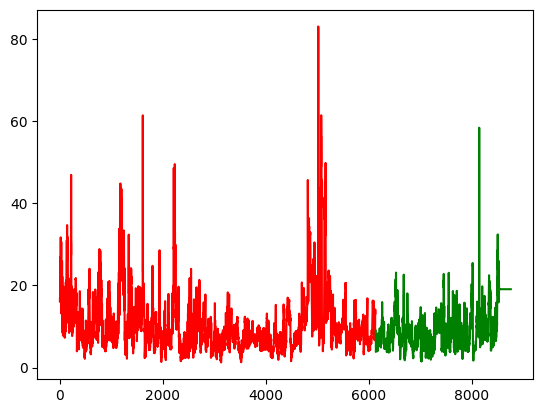

PM 2.5 Model
Epoch 0: train RMSE 2.0071, test RMSE 2.3023, train R2 0.9183, test R2 0.8165
Epoch 1: train RMSE 2.0252, test RMSE 2.2251, train R2 0.9169, test R2 0.8286
Epoch 2: train RMSE 1.9468, test RMSE 2.2775, train R2 0.9232, test R2 0.8205
Epoch 3: train RMSE 1.8618, test RMSE 2.2994, train R2 0.9297, test R2 0.8170
Epoch 4: train RMSE 1.8844, test RMSE 2.3166, train R2 0.9280, test R2 0.8143
Epoch 5: train RMSE 1.8959, test RMSE 2.3139, train R2 0.9271, test R2 0.8147
Epoch 6: train RMSE 1.8671, test RMSE 2.2666, train R2 0.9293, test R2 0.8222
Epoch 7: train RMSE 1.8620, test RMSE 2.2244, train R2 0.9297, test R2 0.8288
Epoch 8: train RMSE 1.8656, test RMSE 2.2072, train R2 0.9295, test R2 0.8314
Epoch 9: train RMSE 1.9087, test RMSE 2.2901, train R2 0.9261, test R2 0.8185


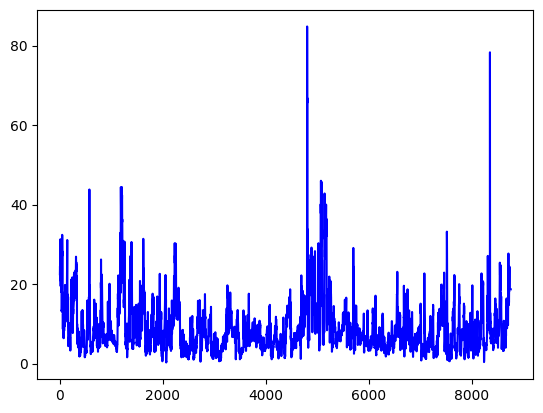

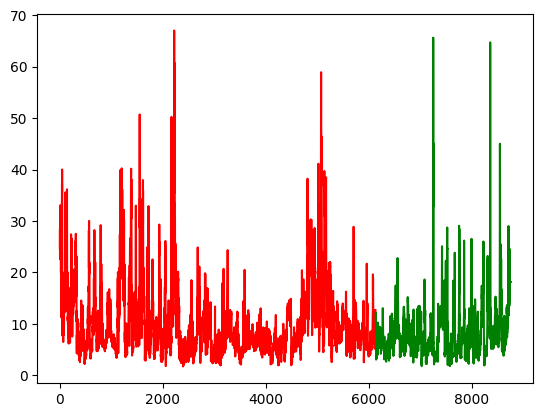

PM 2.5 Model
Epoch 0: train RMSE 3.6167, test RMSE 1.9208, train R2 0.8225, test R2 0.7792
Epoch 1: train RMSE 3.4189, test RMSE 1.9530, train R2 0.8414, test R2 0.7718
Epoch 2: train RMSE 3.3186, test RMSE 1.7355, train R2 0.8506, test R2 0.8198
Epoch 3: train RMSE 2.9129, test RMSE 1.7008, train R2 0.8849, test R2 0.8269
Epoch 4: train RMSE 3.0458, test RMSE 1.6338, train R2 0.8741, test R2 0.8403
Epoch 5: train RMSE 2.8865, test RMSE 1.7473, train R2 0.8869, test R2 0.8173
Epoch 6: train RMSE 3.4514, test RMSE 1.6585, train R2 0.8384, test R2 0.8354
Epoch 7: train RMSE 3.1119, test RMSE 1.6476, train R2 0.8686, test R2 0.8376
Epoch 8: train RMSE 3.0048, test RMSE 1.6859, train R2 0.8775, test R2 0.8299
Epoch 9: train RMSE 2.9844, test RMSE 1.6624, train R2 0.8792, test R2 0.8346


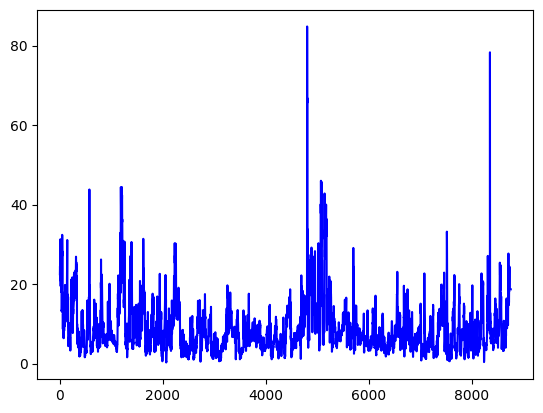

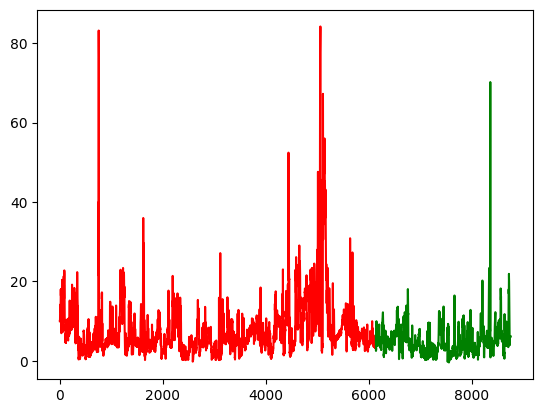

PM 2.5 Model
Epoch 0: train RMSE 2.3436, test RMSE 2.4824, train R2 0.9279, test R2 0.7690
Epoch 1: train RMSE 2.1716, test RMSE 2.3101, train R2 0.9381, test R2 0.7999
Epoch 2: train RMSE 1.9889, test RMSE 2.4327, train R2 0.9481, test R2 0.7781
Epoch 3: train RMSE 1.9986, test RMSE 2.3424, train R2 0.9476, test R2 0.7943
Epoch 4: train RMSE 2.0899, test RMSE 2.3236, train R2 0.9427, test R2 0.7976
Epoch 5: train RMSE 1.9934, test RMSE 2.2717, train R2 0.9478, test R2 0.8065
Epoch 6: train RMSE 1.9217, test RMSE 2.4158, train R2 0.9515, test R2 0.7812
Epoch 7: train RMSE 1.9588, test RMSE 2.2276, train R2 0.9496, test R2 0.8139
Epoch 8: train RMSE 1.9461, test RMSE 2.4098, train R2 0.9503, test R2 0.7823
Epoch 9: train RMSE 1.8787, test RMSE 2.3445, train R2 0.9537, test R2 0.7939


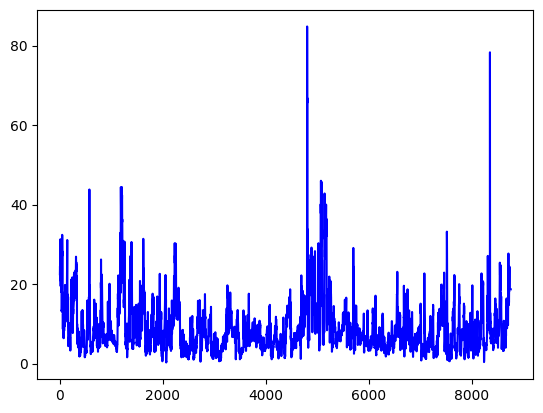

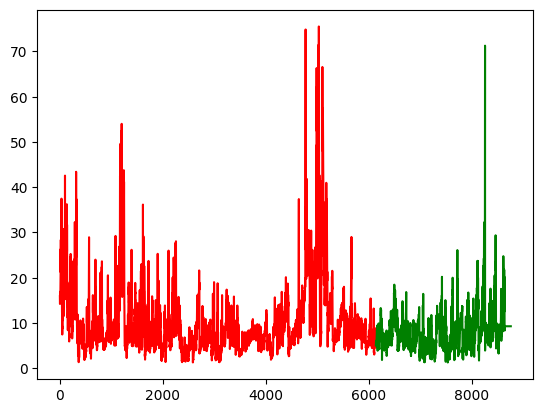

PM 2.5 Model
Epoch 0: train RMSE 2.2928, test RMSE 2.1266, train R2 0.9213, test R2 0.8601
Epoch 1: train RMSE 2.0850, test RMSE 2.0571, train R2 0.9349, test R2 0.8691
Epoch 2: train RMSE 2.0097, test RMSE 2.0814, train R2 0.9395, test R2 0.8660
Epoch 3: train RMSE 1.8681, test RMSE 2.1765, train R2 0.9477, test R2 0.8534
Epoch 4: train RMSE 1.9337, test RMSE 2.1507, train R2 0.9440, test R2 0.8569
Epoch 5: train RMSE 1.8108, test RMSE 2.1077, train R2 0.9509, test R2 0.8626
Epoch 6: train RMSE 1.8003, test RMSE 2.1052, train R2 0.9515, test R2 0.8629
Epoch 7: train RMSE 1.8995, test RMSE 2.0650, train R2 0.9460, test R2 0.8681
Epoch 8: train RMSE 1.8162, test RMSE 2.0498, train R2 0.9506, test R2 0.8700
Epoch 9: train RMSE 1.8870, test RMSE 2.0825, train R2 0.9467, test R2 0.8658


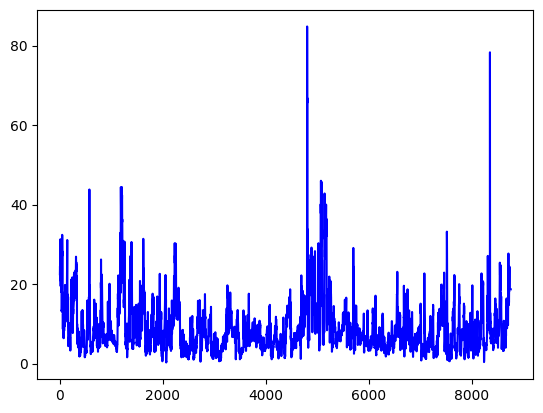

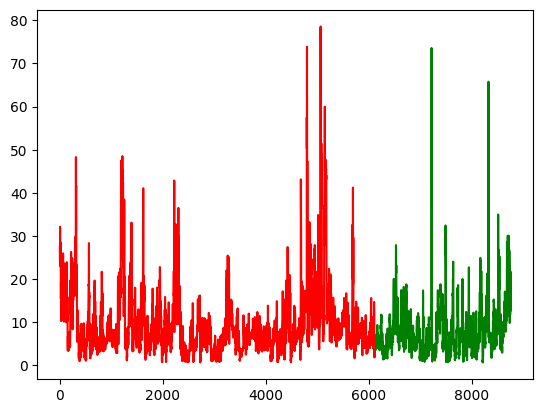

PM 2.5 Model
Epoch 0: train RMSE 2.1940, test RMSE 2.4891, train R2 0.9097, test R2 0.8447
Epoch 1: train RMSE 2.1792, test RMSE 2.4715, train R2 0.9109, test R2 0.8469
Epoch 2: train RMSE 2.1742, test RMSE 2.4962, train R2 0.9113, test R2 0.8438
Epoch 3: train RMSE 2.1234, test RMSE 2.5324, train R2 0.9154, test R2 0.8393
Epoch 4: train RMSE 2.1406, test RMSE 2.5688, train R2 0.9140, test R2 0.8346
Epoch 5: train RMSE 2.1021, test RMSE 2.4717, train R2 0.9171, test R2 0.8469
Epoch 6: train RMSE 2.0694, test RMSE 2.4898, train R2 0.9197, test R2 0.8446
Epoch 7: train RMSE 2.1195, test RMSE 2.5097, train R2 0.9157, test R2 0.8421
Epoch 8: train RMSE 2.0763, test RMSE 2.5024, train R2 0.9191, test R2 0.8431
Epoch 9: train RMSE 2.0556, test RMSE 2.4987, train R2 0.9207, test R2 0.8435


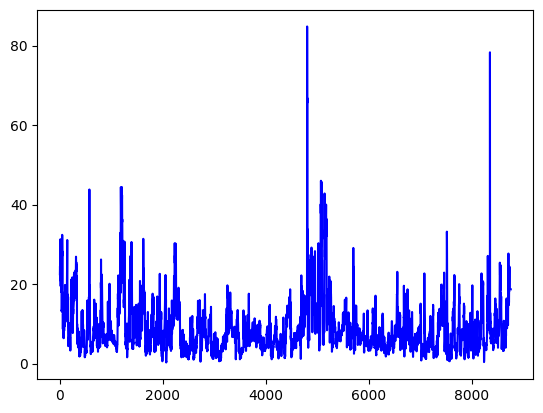

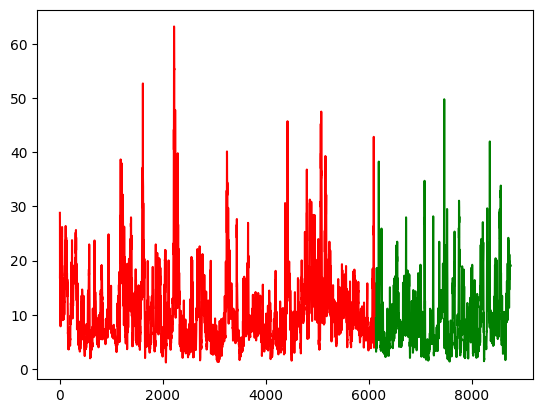

PM 2.5 Model
Epoch 0: train RMSE 1.6150, test RMSE 1.6560, train R2 0.9425, test R2 0.8810
Epoch 1: train RMSE 1.5754, test RMSE 1.6465, train R2 0.9453, test R2 0.8824
Epoch 2: train RMSE 1.5967, test RMSE 1.6991, train R2 0.9438, test R2 0.8747
Epoch 3: train RMSE 1.6362, test RMSE 1.8028, train R2 0.9410, test R2 0.8590
Epoch 4: train RMSE 1.5537, test RMSE 1.7216, train R2 0.9468, test R2 0.8714
Epoch 5: train RMSE 1.7068, test RMSE 1.7935, train R2 0.9358, test R2 0.8604
Epoch 6: train RMSE 1.6732, test RMSE 1.7651, train R2 0.9383, test R2 0.8648
Epoch 7: train RMSE 1.5491, test RMSE 1.7362, train R2 0.9471, test R2 0.8692
Epoch 8: train RMSE 1.5371, test RMSE 1.6900, train R2 0.9479, test R2 0.8760
Epoch 9: train RMSE 1.5718, test RMSE 1.7503, train R2 0.9455, test R2 0.8670


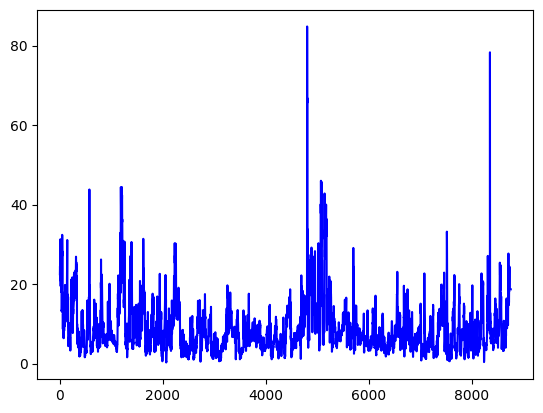

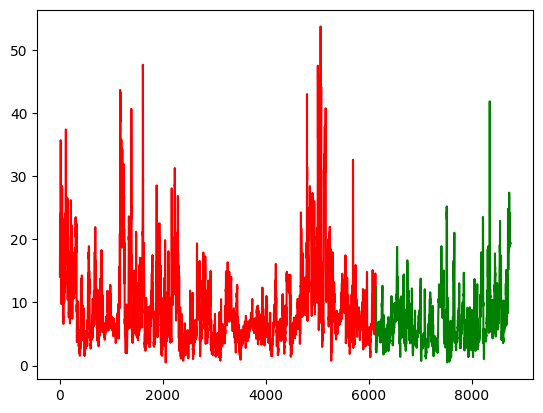

In [15]:
import torch.optim as optim
import torch.utils.data as data

def r2_score(predicted, target):
    mean_target = torch.mean(target)
    total_variance = torch.sum((target - mean_target)**2)
    residual_variance = torch.sum((target - predicted)**2)
    r_squared = 1 - (residual_variance / total_variance)

    return r_squared.item()

for i in range(len(station_data)):
  X_train = torch.tensor(station_train_dataset[i][0], dtype=torch.float)
  y_train = torch.tensor(station_train_dataset[i][1], dtype=torch.float)
  X_test = torch.tensor(station_test_dataset[i][0], dtype=torch.float)
  y_test = torch.tensor(station_test_dataset[i][1], dtype=torch.float)

  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
  n_epochs = 10
  loss_fn = nn.MSELoss()
  input_size = 1
  stat_train_predictions = []
  stat_test_predictions = []
  def models(loader, X_train, y_train, X_test, y_test):
    model = LSTM_Model(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(n_epochs):
        model.train()
        avg_loss = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            avg_loss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(np.mean(avg_loss))
        # Validation
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            stat_train_predictions.append(y_pred)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            r2_score_train = r2_score(y_pred, y_train)
            y_pred = model(X_test)
            stat_test_predictions.append(y_pred)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            r2_score_test = r2_score(y_pred, y_test)

        print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, r2_score_train, r2_score_test))
    return model, losses

  print("PM 2.5 Model")
  pm25_model, pm25_losses = models(loader, X_train, y_train, X_test, y_test)
  plot(pm25_model, station_data[0], train_size, X_train, y_train, X_test, y_test)

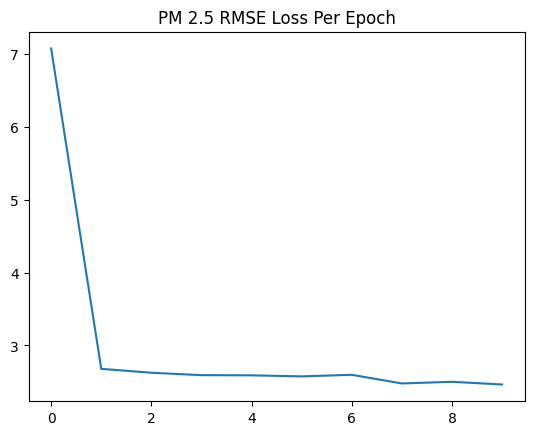

In [17]:
plt.title("PM 2.5 RMSE Loss Per Epoch")
plt.plot(pm25_losses, label="pm25 loss")
plt.show()

# Try try again, closer version

note that the files for processed monitor are stored in content when on colab but might be different when local

In [20]:
!pip install networkx torchvision

In [74]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
import networkx as nx
from heapq import nsmallest
import pandas as pd
import re
import glob

In [75]:
directory_path = '/content/'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")


In [76]:
directory_path = '/content/'
file_names = glob.glob(os.path.join(directory_path, '*.csv'))

In [77]:
nodes = list(range(len(data_frames)))

In [78]:
def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

G = nx.Graph()

distances = {}
for i in range(len(data_frames)):
    distances[i] = []
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)


In [79]:
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

In [90]:
num_features = 1
num_classes = 17
node_features = stat_train_predictions
regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
targets_tensor = torch.tensor(regression_targets, dtype=torch.float)
data = Data(edge_index=edge_index, x=node_features)
data.y = targets_tensor

<ipython-input-90-91be690d9b1f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(regression_targets, dtype=torch.float)


In [91]:
class BasicGNN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [92]:
model = BasicGNN(num_features,num_classes)

In [93]:
print(data.edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  8,  8,  8,  8, 11, 11, 11,  1,
          1, 14,  2,  3,  3, 16, 16,  4,  4,  4,  9,  9,  9,  5,  5, 13,  6],
        [ 7,  8, 11,  1,  3, 14, 16,  2, 15,  8,  1,  2, 15, 14,  3, 10, 16, 14,
          4,  4, 15, 16, 10,  6, 10,  9,  5, 12,  5, 12, 13, 13, 12,  6, 10]])


In [94]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')


AssertionError: ignored

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
accuracy = correct / data.test_mask.sum().item()

print(f'Accuracy: {accuracy}')
